In [10]:
import numpy as np


def log_posterior_unnorm(
    par: np.ndarray,
    obs: np.ndarray,
    y_obs: np.ndarray,
    sigma_prior: float = 1.0,
    sigma_lik: float = 1.0,
) -> np.ndarray:
    """
    Independent standard-normal prior on 'par' (each dimension),
    independent Gaussian likelihood on 'obs' vs y_obs with sigma_lik.

    Returns unnormalized log posterior for each snapshot i:
      logpi[i] = -0.5 * ||par[i]||^2 / sigma_prior^2
                 -0.5 * ||obs[i] - y_obs||^2 / sigma_lik^2
    (constants dropped; fine for MH ratios)
    """
    par = np.asarray(par, dtype=np.float64)
    obs = np.asarray(obs, dtype=np.float64)
    y_obs = np.asarray(y_obs, dtype=np.float64)
    if obs.shape[1] != y_obs.shape[0]:
        raise ValueError(f"y_obs has length {y_obs.shape[0]}, expected {obs.shape[1]}")

    lp_prior = -0.5 * np.sum((par / sigma_prior) ** 2, axis=1)
    resid = obs - y_obs[None, :]
    lp_lik = -0.5 * np.sum((resid / sigma_lik) ** 2, axis=1)
    return lp_prior + lp_lik

In [11]:
import h5py
import numpy as np

with h5py.File("data.h5", "r") as f:
    par   = f["par"][:]
    obs   = f["obs"][:]
    y_obs = f["y_obs"][:]
    logpi = f["logpi"][:]
    chain = f["chain"][:]
    props = f["props"][:]


In [12]:
chain = np.zeros((28324 - 1)*2, dtype=np.int32)
props = np.zeros((28324 - 1) * 2, dtype=np.int32)
chain[0::2] = np.arange(1, 28324)
chain[1::2] = np.arange(28324 - 1)
props[0::2] = np.arange(28324 - 1)
props[1::2] = np.arange(1, 28324)

In [6]:
import h5py
import numpy as np


def save_mlp_data_to_hdf5(
    filename: str,
    par: np.ndarray,
    obs: np.ndarray,
    y_obs: np.ndarray,
    logpi: np.ndarray,
    chain: np.ndarray,
    props: np.ndarray,
):
    """
    Save current in-memory arrays into an HDF5 file for MLP tests.

    Expected shapes:
      par   : (N, 30)
      obs   : (N, 52)
      y_obs : (52,)
      logpi : (N,)
      chain : (T,)
      props : (T,)
    """

    # Basic shape checks (optional but useful)
    N = par.shape[0]
    assert obs.shape[0] == N, "obs and par must have same first dimension"
    assert logpi.shape[0] == N, "logpi and par must have same first dimension"
    assert y_obs.shape[0] == obs.shape[1], "y_obs must match obs second dimension"
    assert chain.shape == props.shape, "chain and props must have the same shape"

    with h5py.File(filename, "w") as f:
        # Use gzip compression to keep file smaller (optional)
        f.create_dataset("par", data=par, compression="gzip")
        f.create_dataset("obs", data=obs, compression="gzip")
        f.create_dataset("y_obs", data=y_obs, compression="gzip")
        f.create_dataset("logpi", data=logpi, compression="gzip")
        f.create_dataset("chain", data=chain, compression="gzip")
        f.create_dataset("props", data=props, compression="gzip")

    print(f"Saved data to {filename}")


# Example usage *inside your current session*:
save_mlp_data_to_hdf5("data1.h5", par, obs, y_obs, logpi, chain, props)

Saved data to data1.h5


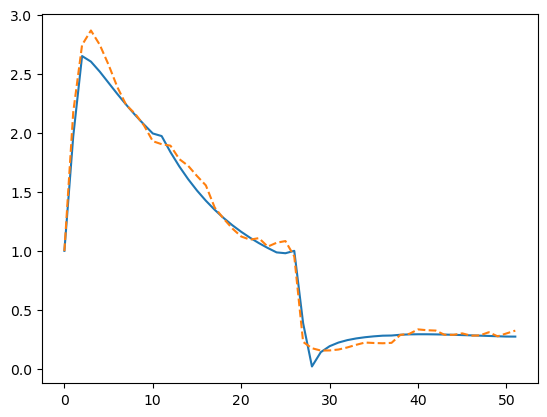

In [ ]:
import matplotlib.pyplot as plt
plt.plot(obs[5000,:] )
plt.plot(y_obs[:], linestyle='dashed' )

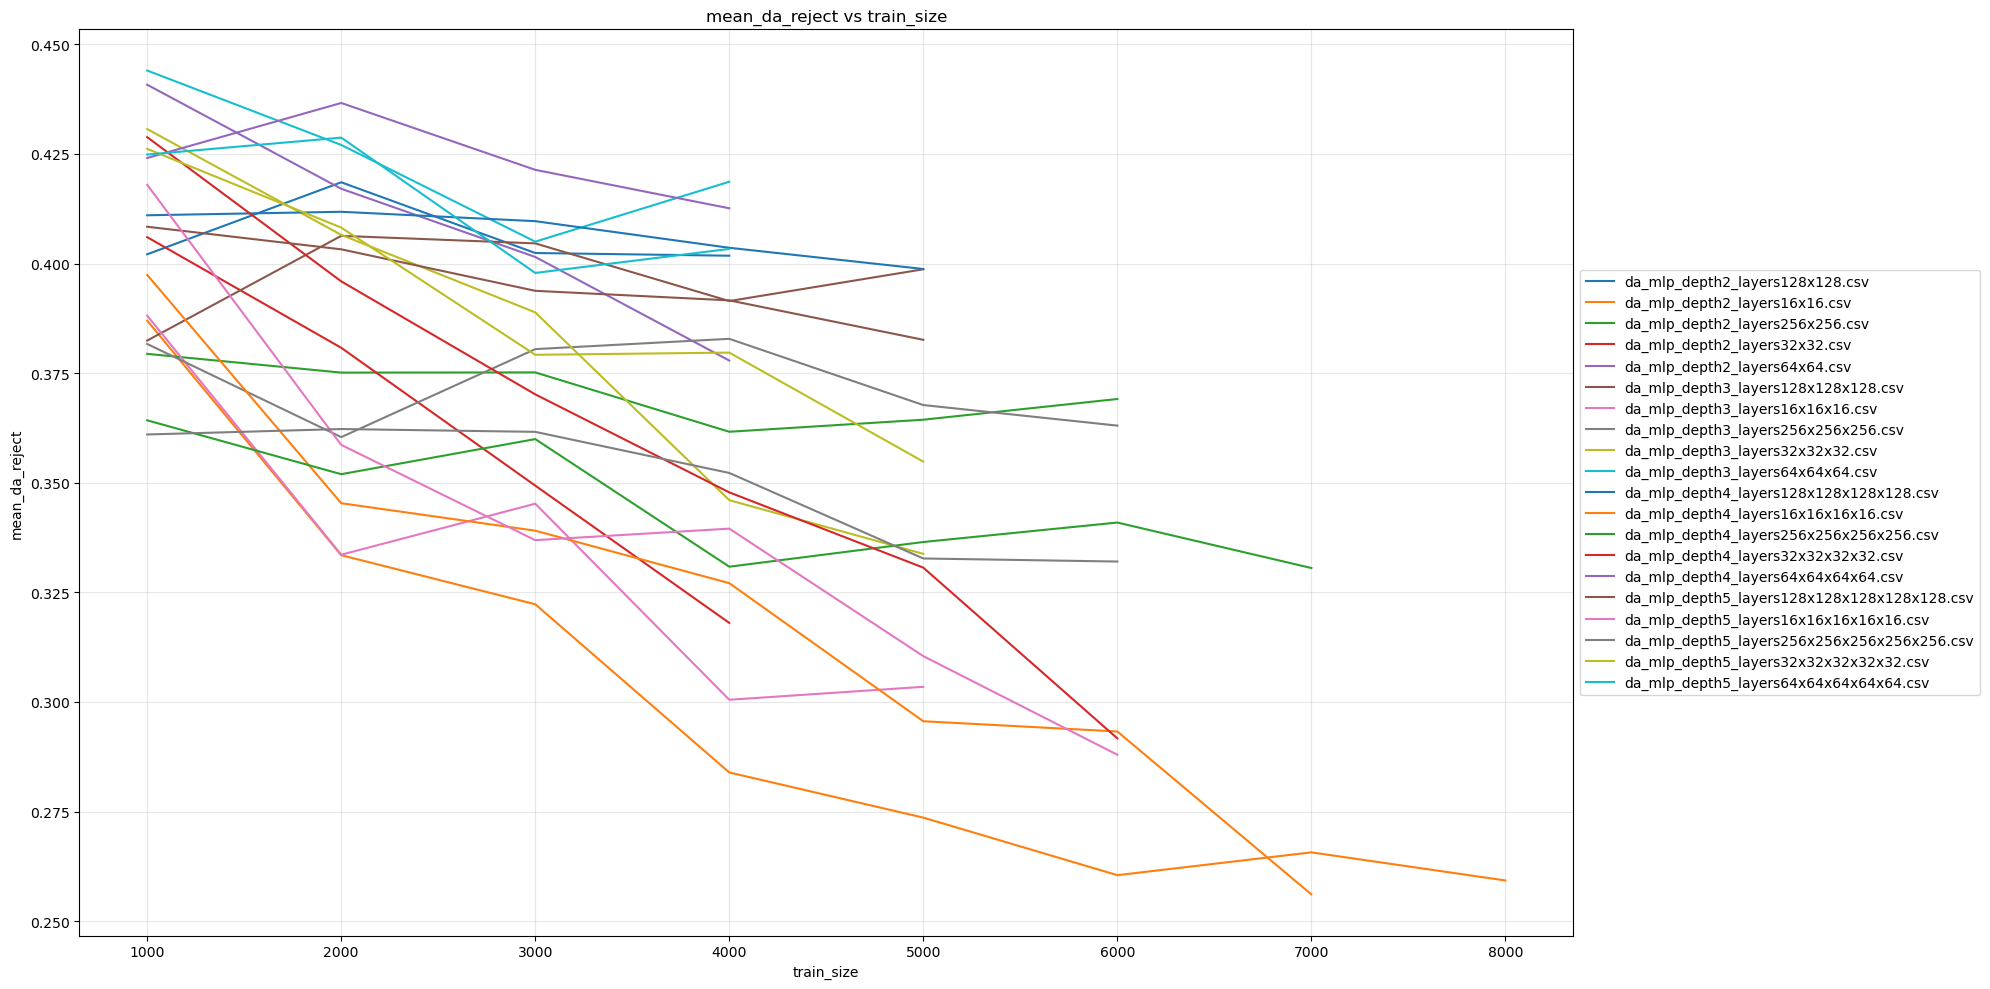

In [15]:
import pandas as pd
used_train_size = False
plt.figure(figsize=(20, 10))
for path in csv_paths:
    df = pd.read_csv(path)
    if "mean_da_reject" not in df.columns:
        continue
    x = df["train_size"] if "train_size" in df.columns else df.index
    used_train_size = used_train_size or "train_size" in df.columns
    plt.plot(x, df["mean_da_reject"], label=os.path.basename(path))

if not used_train_size:
    raise KeyError("Column 'train_size' not found in any CSV in 'results/'.")

plt.xlabel("train_size")
plt.ylabel("mean_da_reject")
plt.title("mean_da_reject vs train_size")
plt.grid(True, alpha=0.3)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()

In [121]:
import os

# Collect all CSV file paths under results_MSE (recursively)
try:
    os  # use os imported in a later cell if available
except NameError:
    pass

base_dir = "results_new_MSE"
if not os.path.isdir(base_dir):
    raise FileNotFoundError(f"Directory '{base_dir}' not found.")

csv_paths = sorted(
    os.path.join(root, fname)
    for root, _, files in os.walk(base_dir)
    for fname in files
    if fname.lower().endswith(".csv")
)

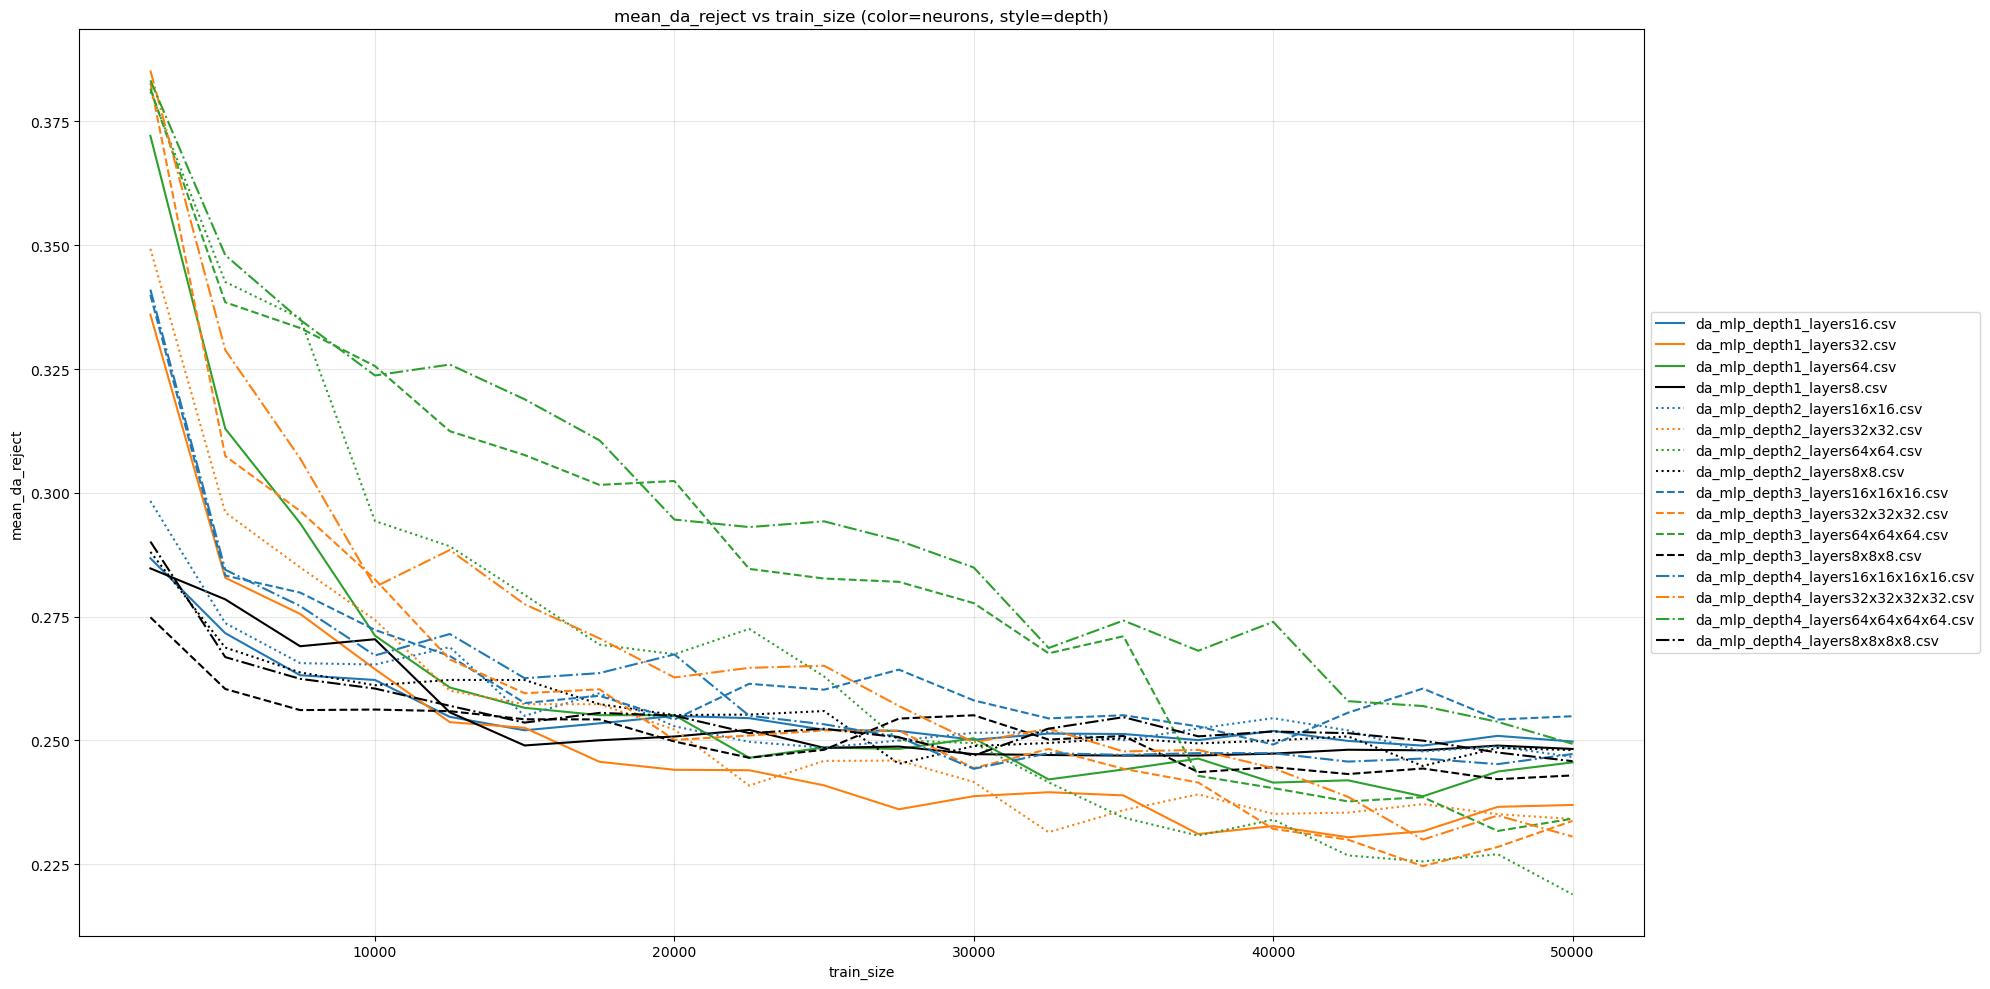

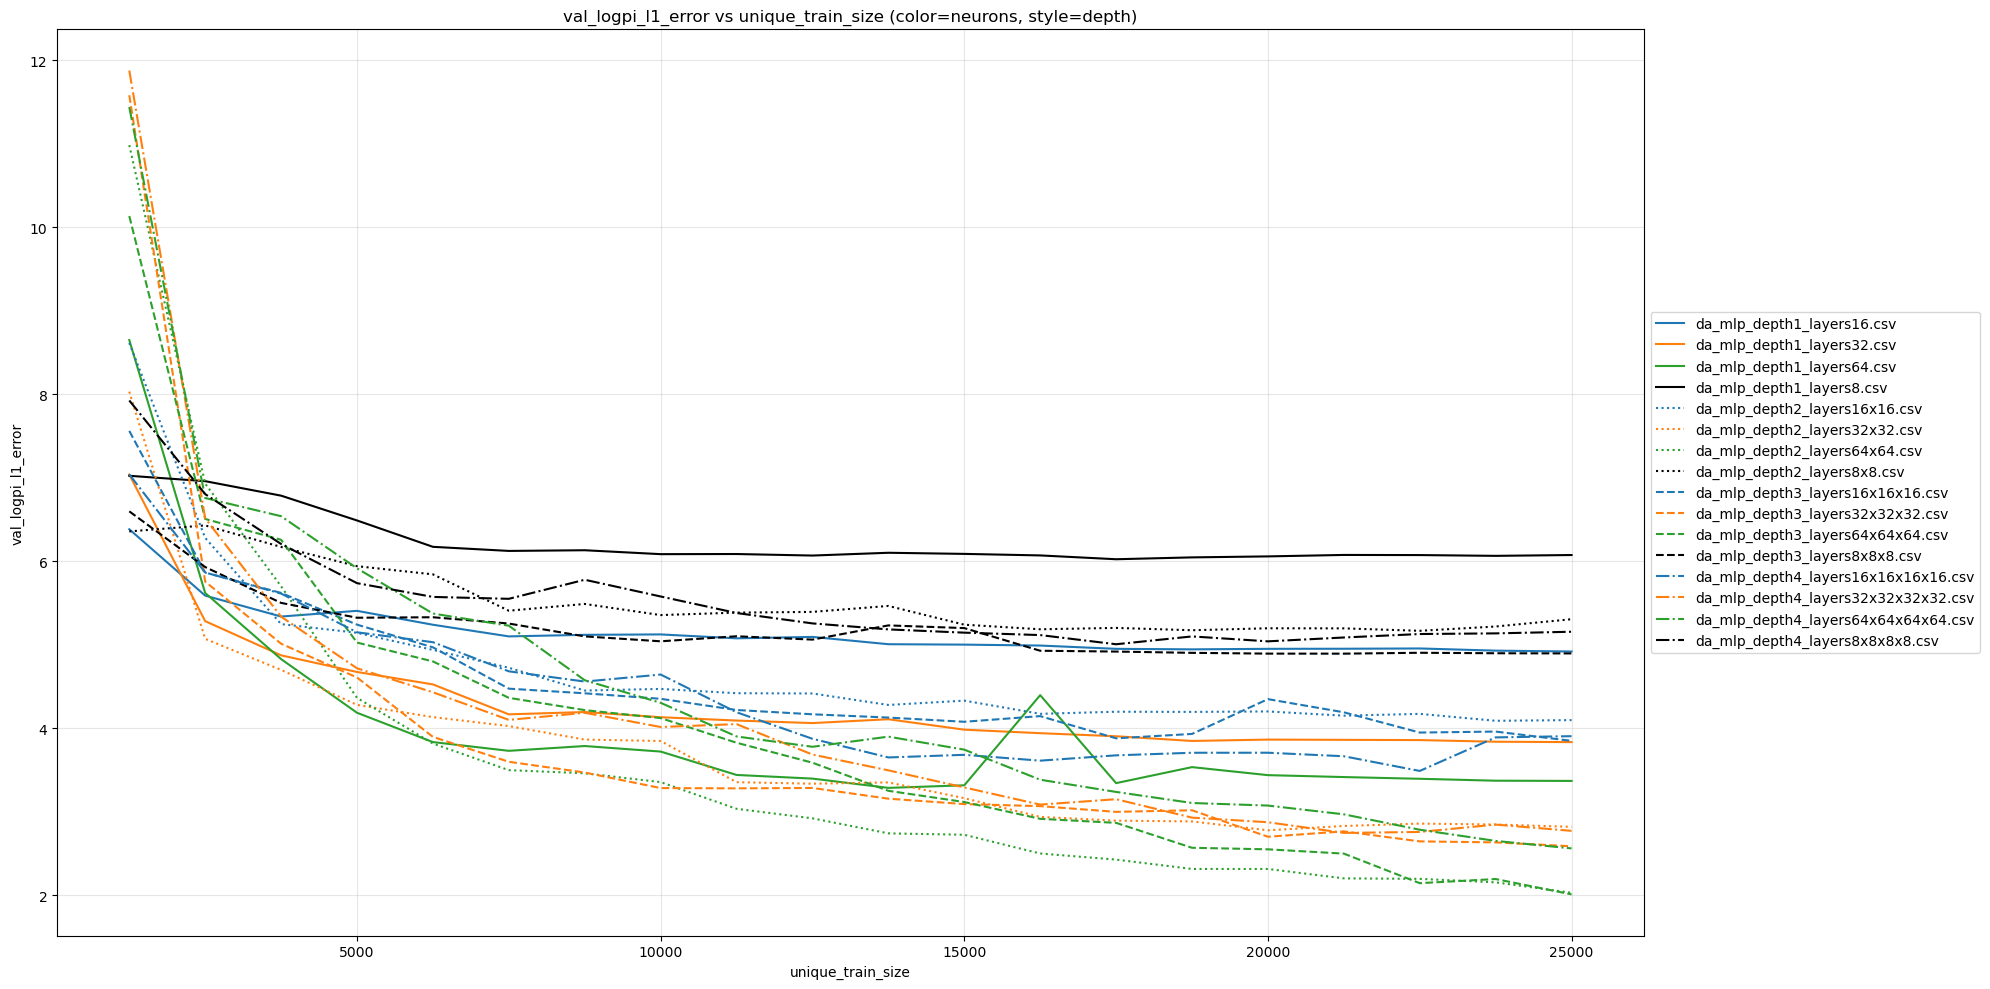

In [122]:
import os

# Color by neurons per layer; linestyle by depth (number of repeated layers)
color_map = {16: 'tab:blue', 32: 'tab:orange', 64: 'tab:green', 128: 'tab:red', 256: 'tab:purple'}
linestyle_map = {2: ':', 3: '--', 4: '-.', 5: '-'}

plt.figure(figsize=(20, 10))

for path in csv_paths:
    fname = os.path.basename(path)
    if "layers" not in fname:
        continue

    # Parse neurons per layer and depth from filename e.g. da_mlp_depth3_layers128x128x128.csv
    layer_part = fname.split("layers", 1)[1].split(".csv", 1)[0]  # '128x128x128'
    sizes = layer_part.split('x')
    if not sizes or not sizes[0].isdigit():
        continue

    neurons = int(sizes[0])
    depth = len(sizes)

    color = color_map.get(neurons, 'k')
    linestyle = linestyle_map.get(depth, '-')

    d = pd.read_csv(path)
    if "mean_da_reject" not in d.columns:
        continue

    x_vals = d["train_size"] if "train_size" in d.columns else d.index
    plt.plot(x_vals, d["mean_da_reject"], label=f"{fname}", color=color, linestyle=linestyle)

plt.xlabel("train_size")
plt.ylabel("mean_da_reject")
plt.title("mean_da_reject vs train_size (color=neurons, style=depth)")
plt.grid(True, alpha=0.3)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()


# Plot val_logpi_l1_error vs unique_train_size with color=neurons, linestyle=depth
plt.figure(figsize=(20, 10))
plotted = False

for path in csv_paths:
    fname = os.path.basename(path)
    if "layers" not in fname:
        continue

    layer_part = fname.split("layers", 1)[1].split(".csv", 1)[0]
    sizes = layer_part.split('x')
    if not sizes or not sizes[0].isdigit():
        continue
    neurons = int(sizes[0])
    depth = len(sizes)

    color = color_map.get(neurons, 'k')
    linestyle = linestyle_map.get(depth, '-')

    d = pd.read_csv(path)
    if "val_logpi_l1_error" not in d.columns:
        continue

    x_vals = d["unique_train_size"] if "unique_train_size" in d.columns else d.index
    plt.plot(x_vals, d["val_logpi_l1_error"], label=fname, color=color, linestyle=linestyle)
    plotted = True

if not plotted:
    raise RuntimeError("No CSV contained 'val_logpi_l1_error'.")

plt.xlabel("unique_train_size")
plt.ylabel("val_logpi_l1_error")
plt.title("val_logpi_l1_error vs unique_train_size (color=neurons, style=depth)")
plt.grid(True, alpha=0.3)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()

In [299]:
import os

# Collect all CSV file paths under results_MSE (recursively)
try:
    os  # use os imported in a later cell if available
except NameError:
    pass

base_dir = "results_tanh_L1"
if not os.path.isdir(base_dir):
    raise FileNotFoundError(f"Directory '{base_dir}' not found.")

csv_paths = sorted(
    os.path.join(root, fname)
    for root, _, files in os.walk(base_dir)
    for fname in files
    if fname.lower().endswith(".csv")
)

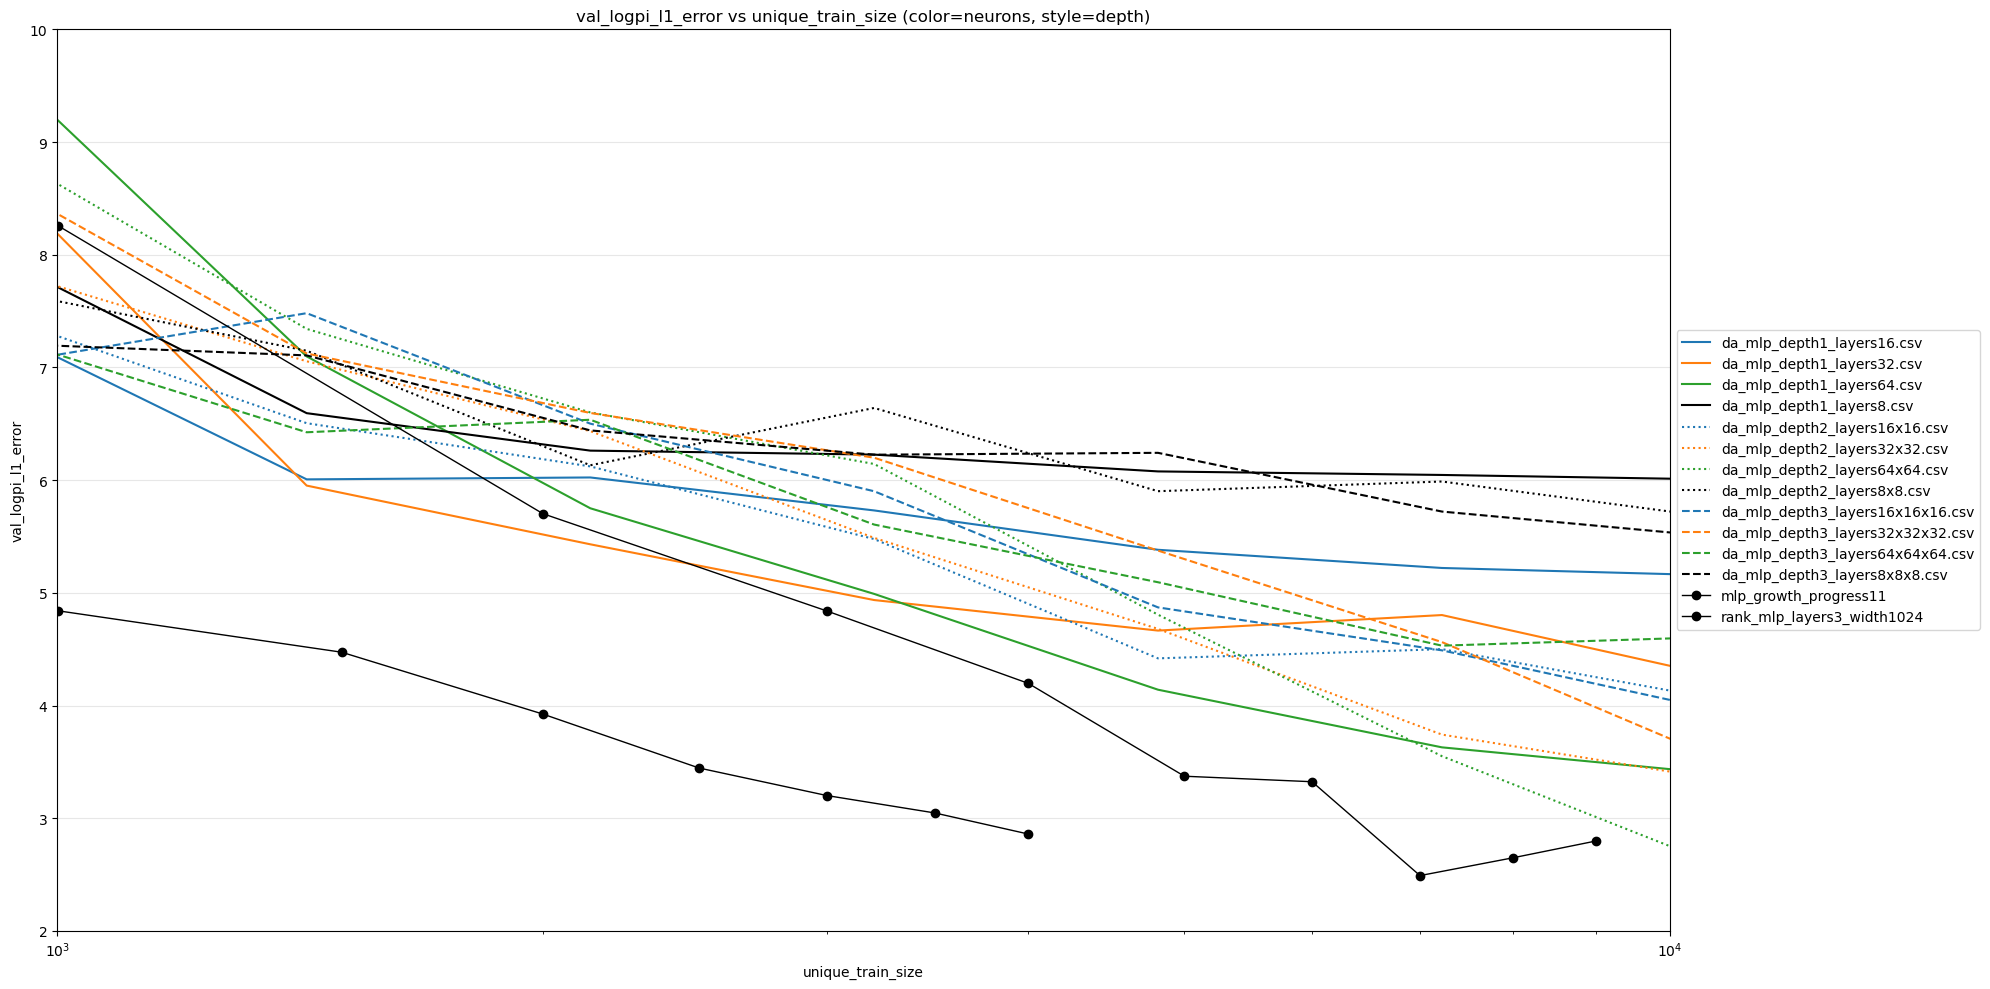

In [302]:
# Plot val_logpi_l1_error vs unique_train_size with color=neurons, linestyle=depth
plt.figure(figsize=(20, 10))
plotted = False

for path in csv_paths:
    fname = os.path.basename(path)
    if "layers" not in fname:
        continue

    layer_part = fname.split("layers", 1)[1].split(".csv", 1)[0]
    sizes = layer_part.split('x')
    if not sizes or not sizes[0].isdigit():
        continue
    neurons = int(sizes[0])
    depth = len(sizes)

    color = color_map.get(neurons, 'k')
    linestyle = linestyle_map.get(depth, '-')

    d = pd.read_csv(path)
    if "val_logpi_l1_error" not in d.columns:
        continue

    x_vals = d["unique_train_size"] if "unique_train_size" in d.columns else d.index
    plt.plot(x_vals, d["val_logpi_l1_error"], label=fname, color=color, linestyle=linestyle)
    plotted = True

if not plotted:
    raise RuntimeError("No CSV contained 'val_logpi_l1_error'.")

# Overlay: plot mlp_growth_progress2 with x = train_limit/2 + 1 and y = master_val_error
gp_path = None
filename_growing = "mlp_growth_progress11"
candidates = [
    filename_growing + ".csv",
    os.path.join("results_tanh_L1", filename_growing + ".csv"),
    filename_growing,
]
for cand in candidates:
    if os.path.isfile(cand):
        gp_path = cand
        break
if gp_path is None:
    for r, _, files in os.walk("."):
        for fn in files:
            if fn.lower().endswith(".csv") and filename_growing in fn:
                gp_path = os.path.join(r, fn)
                break
        if gp_path:
            break
if gp_path is None:
    raise FileNotFoundError(f"Could not find {filename_growing} CSV.")

gdf = pd.read_csv(gp_path)
required_cols = {"train_limit", "master_val_error"}
if not required_cols.issubset(gdf.columns):
    missing = required_cols - set(gdf.columns)
    raise KeyError(f"{filename_growing} missing columns: {missing}")

x_gp = gdf["train_limit"] / 2.0 + 1.0
y_gp = gdf["master_val_error"].astype(float)
mask = (x_gp > 0) & (y_gp > 0)
x_gp = x_gp[mask].to_numpy()
y_gp = y_gp[mask].to_numpy()
order = np.argsort(x_gp)
plt.plot(x_gp[order], y_gp[order], marker='o', linestyle='-', color='k', label=filename_growing, linewidth=1)


filename_growing = "rank_mlp_layers3_width1024"  # "rank_mlp_progress4"  # "rank_mlp_progress_2L_4"   #
candidates = [
    filename_growing + ".csv",
    os.path.join("results_tanh_L3", filename_growing + ".csv"),
    filename_growing,
]
for cand in candidates:
    if os.path.isfile(cand):
        gp_path = cand
        break
if gp_path is None:
    for r, _, files in os.walk("."):
        for fn in files:
            if fn.lower().endswith(".csv") and filename_growing in fn:
                gp_path = os.path.join(r, fn)
                break
        if gp_path:
            break
if gp_path is None:
    raise FileNotFoundError(f"Could not find {filename_growing} CSV.")

gdf = pd.read_csv(gp_path)
required_cols = {"train_steps", "master_logpi_l1"}
if not required_cols.issubset(gdf.columns):
    missing = required_cols - set(gdf.columns)
    raise KeyError(f"{filename_growing} missing columns: {missing}")

x_gp = gdf["train_steps"] / 2.0 + 1.0
y_gp = gdf["master_logpi_l1"].astype(float)
mask = (x_gp > 0) & (y_gp > 0)
x_gp = x_gp[mask].to_numpy()
y_gp = y_gp[mask].to_numpy()
order = np.argsort(x_gp)
plt.plot(x_gp[order], y_gp[order], marker='o', linestyle='-', color='k', label=filename_growing, linewidth=1)

plt.xlabel("unique_train_size")
plt.ylabel("val_logpi_l1_error")
plt.title("val_logpi_l1_error vs unique_train_size (color=neurons, style=depth)")
plt.xscale("log")
#plt.yscale("log")
plt.xlim([1000, 10000])
plt.ylim([2,10])
plt.grid(True, alpha=0.3)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()

Found directories: ['results_tanh_Retrain_new']
Applied filters: neurons=[8, 16, 32], depths=[1, 3]; kept 6/15 curves.


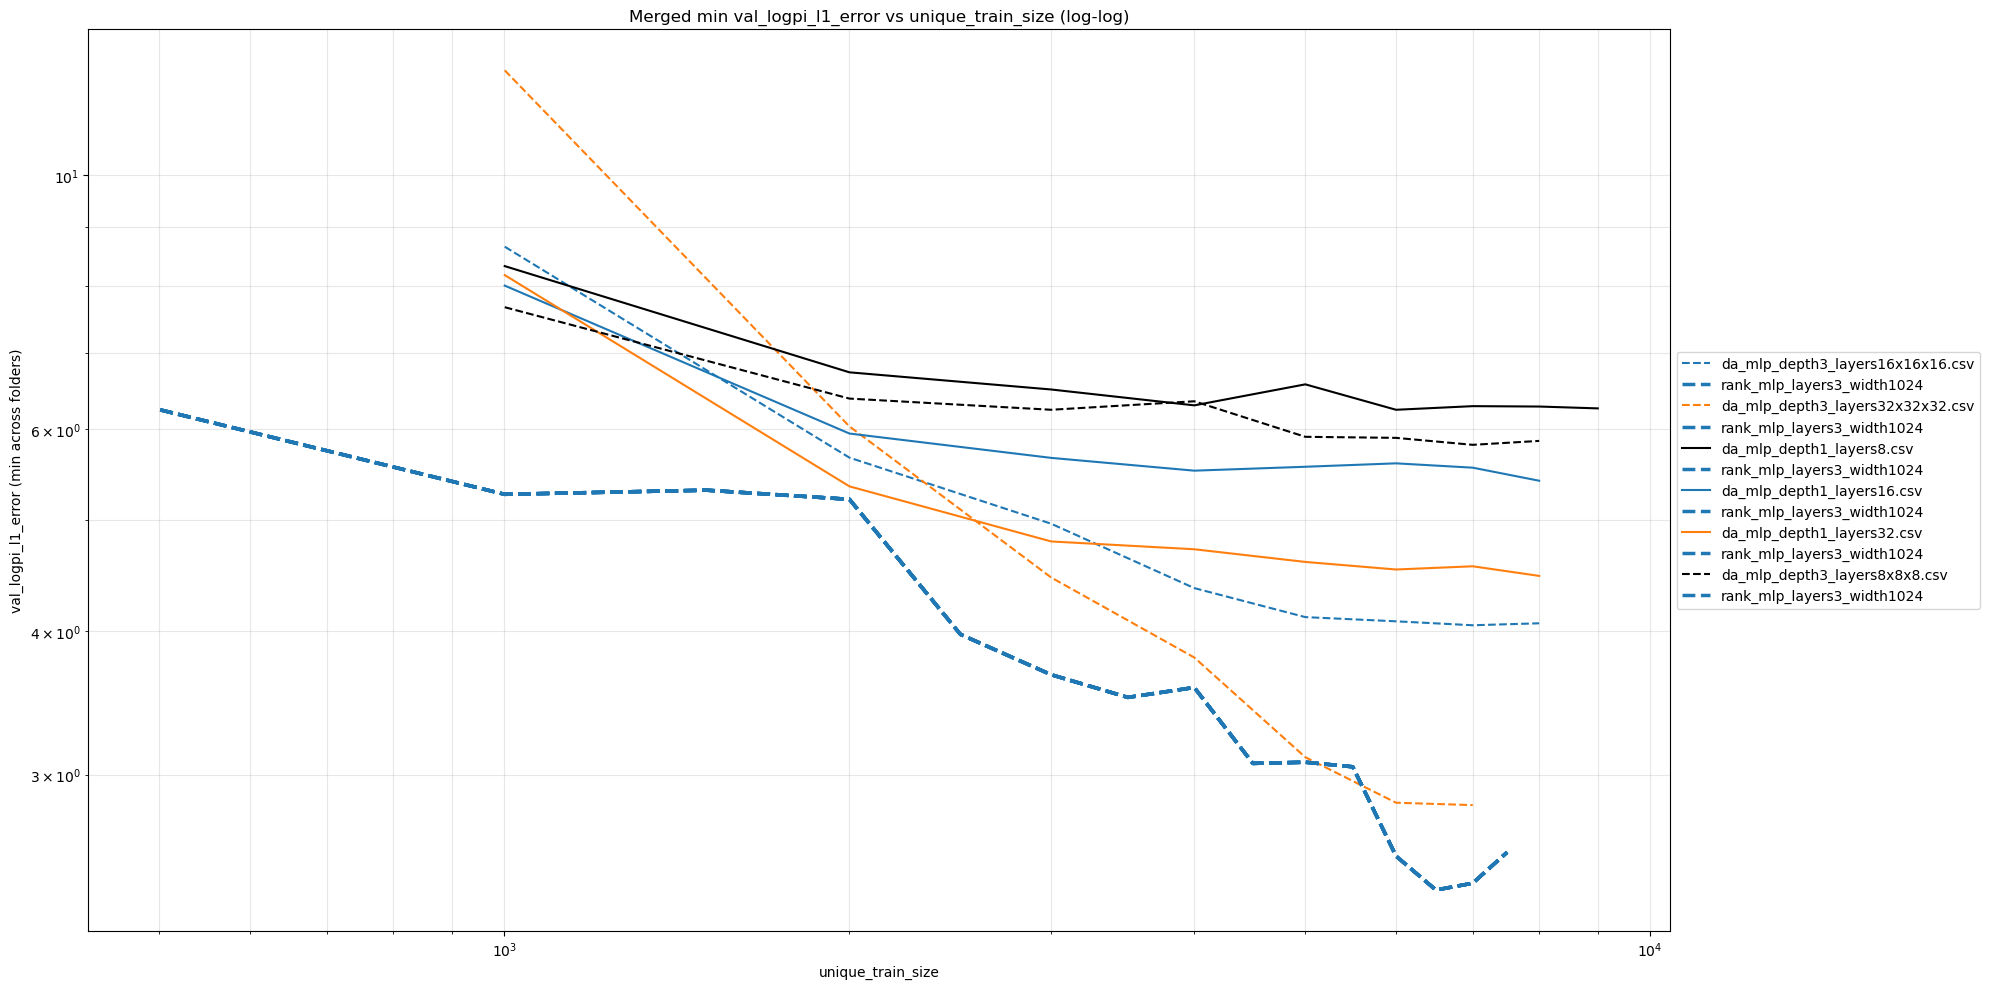

In [315]:
from collections import defaultdict

# Toggles: filter by neurons-per-layer and by depth (number of hidden layers).
# Leave empty lists to include all.
allowed_neurons = [8, 16, 32]  # e.g., [64, 128, 256]
allowed_depths  = [1, 3]  # e.g., [2, 3, 4]

# Merge CSVs across all directories starting with 'results_new_MSE*'
prefix = "results_tanh_Retrain_new"
dirs = [d for d in os.listdir(".") if d.startswith(prefix) and os.path.isdir(d)]
if not dirs:
    raise FileNotFoundError(f"No directories starting with '{prefix}' found.")
print(f"Found directories: {dirs}")
all_csv = []
for d in dirs:
    for root, _, files in os.walk(d):
        for fname_ in files:
            if fname_.lower().endswith(".csv"):
                all_csv.append(os.path.join(root, fname_))

groups = defaultdict(list)
for p in all_csv:
    groups[os.path.basename(p)].append(p)

curves = {}
for fname_, paths in groups.items():
    best = {}
    for p in paths:
        df_ = pd.read_csv(p)
        if "unique_train_size" not in df_.columns or "val_logpi_l1_error" not in df_.columns:
            continue
        xs = df_["unique_train_size"].to_numpy()
        ys = df_["val_logpi_l1_error"].to_numpy()
        for xval, yval in zip(xs, ys):
            prev = best.get(xval)
            if prev is None or yval < prev:
                best[xval] = yval
    if best:
        xs_sorted = np.array(sorted(best.keys()))
        ys_sorted = np.array([best[x] for x in xs_sorted])
        curves[fname_] = (xs_sorted, ys_sorted)

if not curves:
    raise RuntimeError("No usable CSV data with required columns found.")

show_only_best = False  # toggle
if show_only_best:
    min_y_by_x = {}
    for xs, ys in curves.values():
        for x, y in zip(xs, ys):
            py = min_y_by_x.get(x)
            if py is None or y < py:
                min_y_by_x[x] = y
    tol = 1e-9
    filtered = {}
    for fname_, (xs, ys) in curves.items():
        if any(ys[i] <= min_y_by_x[x] + tol for i, x in enumerate(xs)):
            filtered[fname_] = (xs, ys)
    curves_to_plot = filtered
    print(f"Filtered to {len(curves_to_plot)} curves (lower envelope contributors).")
else:
    curves_to_plot = curves

# Apply neuron/depth filters
if allowed_neurons or allowed_depths:
    kept = {}
    for fname_, (xs, ys) in curves_to_plot.items():
        neurons = None
        depth = None
        if "layers" in fname_:
            layer_part = fname_.split("layers", 1)[1].split(".csv", 1)[0]
            sizes = layer_part.split('x')
            if sizes and sizes[0].isdigit():
                neurons = int(sizes[0])
                depth = len(sizes)
        pass_neurons = (not allowed_neurons) or (neurons in allowed_neurons)
        pass_depths = (not allowed_depths) or (depth in allowed_depths)
        if pass_neurons and pass_depths:
            kept[fname_] = (xs, ys)
    print(f"Applied filters: neurons={allowed_neurons or 'ALL'}, depths={allowed_depths or 'ALL'}; "
          f"kept {len(kept)}/{len(curves_to_plot)} curves.")
    curves_to_plot = kept

plt.figure(figsize=(20, 10))
for fname_, (xs, ys) in curves_to_plot.items():
    if "layers" in fname_:
        layer_part = fname_.split("layers", 1)[1].split(".csv", 1)[0]
        sizes = layer_part.split('x')
        if sizes and sizes[0].isdigit():
            neurons = int(sizes[0])
            depth = len(sizes)
            color = color_map.get(neurons, 'k')
            linestyle = linestyle_map.get(depth, '-')
        else:
            color = 'k'
            linestyle = '-'
    else:
        color = 'k'
        linestyle = '-'
    plt.loglog(xs, ys, label=fname_, color=color, linestyle=linestyle)
    label_gp = filename_growing if 'filename_growing' in globals() else gp_path.rsplit('.', 1)[0]
    col_gp = color_by_label.get(label_gp, 'k')
    ls_gp = dirs_cfg.get(base_dir, '--') if 'dirs_cfg' in globals() else '--'
    plt.loglog(x_vals.to_numpy(), y_vals.to_numpy(), color=col_gp, linestyle=ls_gp, linewidth=2.5, label=label_gp)
plt.xlabel("unique_train_size")
plt.ylabel("val_logpi_l1_error (min across folders)")
plt.title("Merged min val_logpi_l1_error vs unique_train_size (log-log)")
plt.grid(True, which='both', alpha=0.3)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()

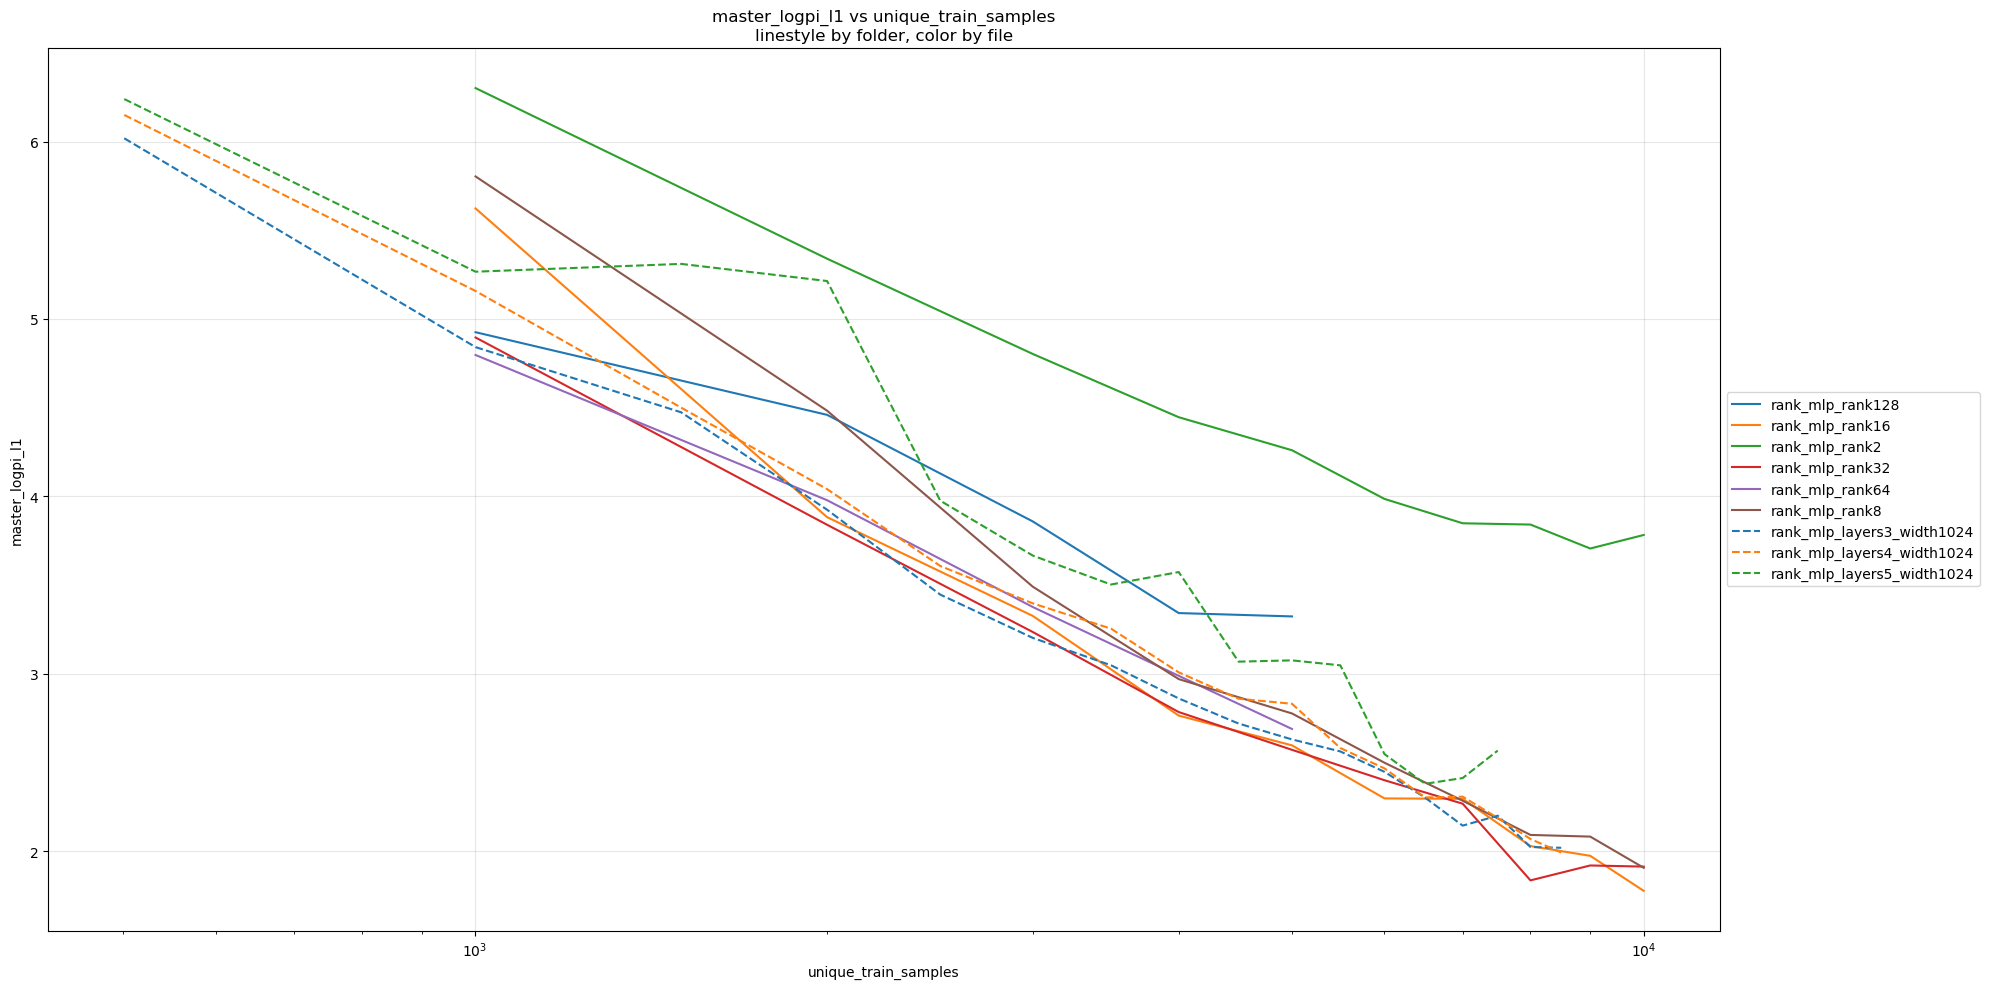

In [314]:
# Plot master_logpi_l1 vs unique_train_samples from two folders:
# - results_fixed_rank_lowrank (linestyle='-')
# - sweep_outputs_10          (linestyle='--')
# Different colors per file within each folder; label is the file stem.

dirs_cfg = {
    "results_fixed_rank_lowrank": "-",
    "sweep_outputs_10": "--",
}

plt.figure(figsize=(20, 10))
plotted = False

for base_dir, ls in dirs_cfg.items():
    if not os.path.isdir(base_dir):
        # Skip silently if a folder is missing
        continue

    csv_paths = sorted(
        os.path.join(root, fname)
        for root, _, files in os.walk(base_dir)
        for fname in files
        if fname.lower().endswith(".csv")
    )
    if not csv_paths:
        continue

    # Build a stable color map per folder based on legend labels (file stems)
    labels = [os.path.splitext(os.path.basename(p))[0] for p in csv_paths]
    unique_labels = sorted(set(labels))
    palette = plt.cm.tab20.colors if len(unique_labels) > 10 else plt.cm.tab10.colors
    color_by_label = {lab: palette[i % len(palette)] for i, lab in enumerate(unique_labels)}

    for path in csv_paths:
        d = pd.read_csv(path)
        if not {"unique_train_samples", "master_logpi_l1"}.issubset(d.columns):
            continue

        x_vals = d["unique_train_samples"].astype(float)
        y_vals = d["master_logpi_l1"].astype(float)
        mask = (x_vals > 0) & np.isfinite(x_vals) & np.isfinite(y_vals)
        if not np.any(mask):
            continue

        x_plot = x_vals[mask].to_numpy()
        y_plot = y_vals[mask].to_numpy()
        order = np.argsort(x_plot)

        label_text = os.path.splitext(os.path.basename(path))[0]  # legend name
        color = color_by_label[label_text]

        plt.plot(x_plot[order], y_plot[order], label=label_text, color=color, linestyle=ls)
        plotted = True

if not plotted:
    raise RuntimeError("No CSV with required columns {'unique_train_samples','master_logpi_l1'} found.")

plt.xlabel("unique_train_samples")
plt.ylabel("master_logpi_l1")
plt.title("master_logpi_l1 vs unique_train_samples\nlinestyle by folder, color by file")
plt.xscale("log")
plt.grid(True, alpha=0.3)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()


In [3]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE, flush=True)

Device: cuda


In [4]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))


2.9.1
13.0
NVIDIA GeForce GTX 1080 Ti


/usr/lib/python3.13/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX 1080 Ti which is of cuda capability 6.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (7.5) - (12.1)
    
  warnings.warn(
/usr/lib/python3.13/site-packages/torch/cuda/__init__.py:304: UserWarning: 
    Please install PyTorch with a following CUDA
    configurations:  12.6 following instructions at
    https://pytorch.org/get-started/locally/
    
  warnings.warn(matched_cuda_warn.format(matched_arches))
/usr/lib/python3.13/site-packages/torch/cuda/__init__.py:326: UserWarning: 
NVIDIA GeForce GTX 1080 Ti with CUDA capability sm_61 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_75 sm_80 sm_86 sm_87 sm_89 sm_90 sm_100 sm_103 sm_110 sm_120 sm_121.
If you want to use the NVIDIA GeForce GTX 1080 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-star

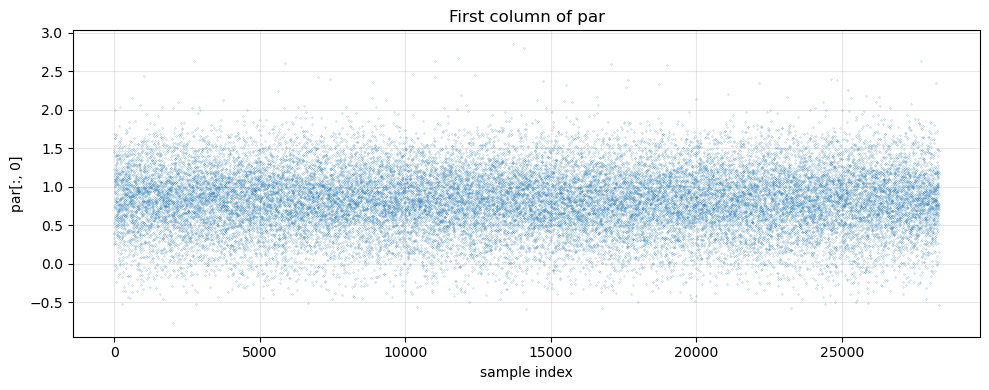

In [67]:
plt.figure(figsize=(10, 4))
plt.plot(par[:, 28],'.',markersize=0.3)
plt.xlabel('sample index')
plt.ylabel('par[:, 0]')
plt.title('First column of par')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

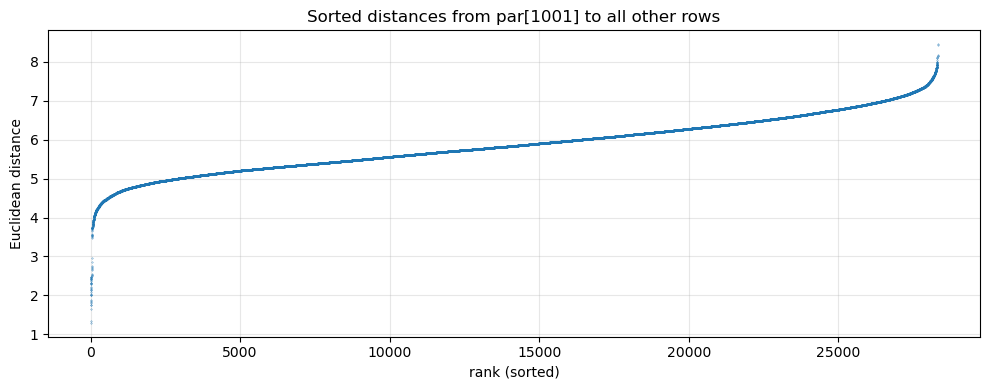

In [70]:
i = 1001
vec = par[i]
dist = np.linalg.norm(par - vec, axis=1)
dist_no_self = dist[np.arange(dist.size) != i]
dist_sorted = np.sort(dist_no_self)

plt.figure(figsize=(10, 4))
plt.plot(dist_sorted, '.', markersize=0.5)
plt.xlabel('rank (sorted)')
plt.ylabel('Euclidean distance')
plt.title(f'Sorted distances from par[{i}] to all other rows')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [72]:
import heapq

# Compute 10 smallest non-zero pairwise distances between rows of par without
# materializing the full (N x N) distance matrix (streaming O(N^2) time, low memory).
# Warning: This will still be compute-intensive for N=28324 (~4e8 pair distances).


N, D = par.shape
k = 10
# Max-heap storing (-distance, i, j); keeps current k smallest distances
heap = []

par_f = par.astype(np.float32, copy=False)

for i in range(N - 1):
    diff = par_f[i+1:] - par_f[i]              # shape (N-i-1, D)
    dists = np.sqrt(np.sum(diff * diff, axis=1))
    # Stream update heap
    for off, dist in enumerate(dists):
        if len(heap) < k:
            heapq.heappush(heap, (-dist, i, i + 1 + off))
        else:
            if dist < -heap[0][0]:
                heapq.heapreplace(heap, (-dist, i, i + 1 + off))
    if (i + 1) % 1000 == 0:
        print(f"Progress {i+1}/{N}", flush=True)

# Extract and sort ascending by distance
pairs = sorted([(-negd, i, j) for (negd, i, j) in heap])

print("10 smallest distances (distance, index_i, index_j):")
for dist, i, j in pairs:
    print(f"{dist:.6f}\t{i}\t{j}")

Progress 1000/28324
Progress 2000/28324
Progress 3000/28324
Progress 4000/28324
Progress 5000/28324
Progress 6000/28324
Progress 7000/28324
Progress 8000/28324
Progress 9000/28324
Progress 10000/28324
Progress 11000/28324
Progress 12000/28324
Progress 13000/28324
Progress 14000/28324
Progress 15000/28324
Progress 16000/28324
Progress 17000/28324
Progress 18000/28324
Progress 19000/28324
Progress 20000/28324
Progress 21000/28324
Progress 22000/28324
Progress 23000/28324
Progress 24000/28324
Progress 25000/28324
Progress 26000/28324
Progress 27000/28324
Progress 28000/28324
10 smallest distances (distance, index_i, index_j):
0.277660	12023	14760
0.288548	788	26302
0.289101	2936	14696
0.293409	8771	14784
0.302534	1311	14151
0.305907	3002	14613
0.307750	1070	7747
0.310918	1908	19835
0.316654	6110	15799
0.317158	11837	15764


Rank 1: distance=0.288548 between par[788] and par[26302]


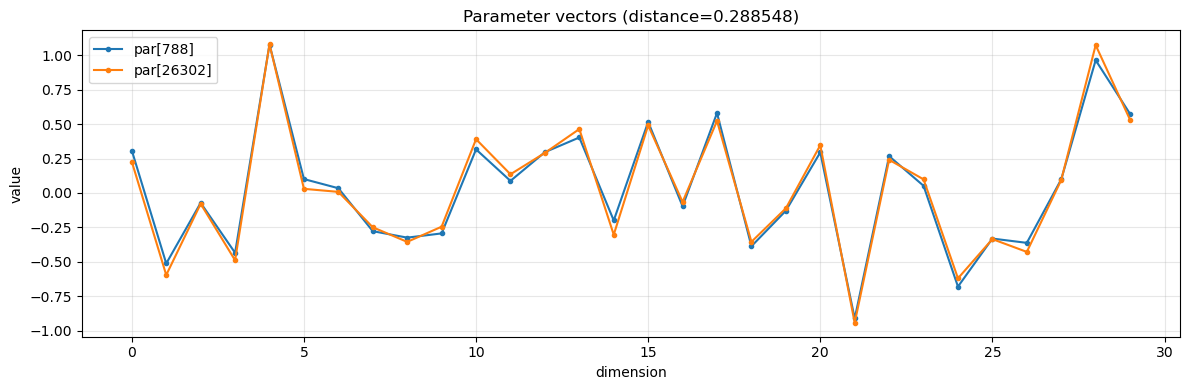

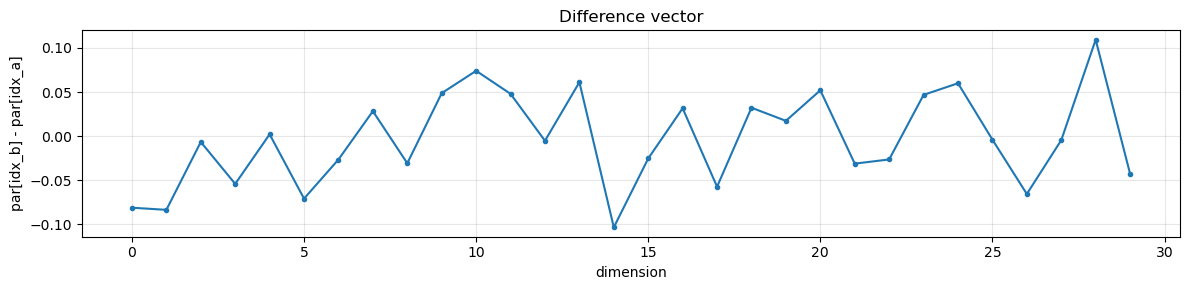

In [74]:
# Plot the ith (rank) smallest pair from 'pairs' (sorted ascending by distance).
# Set pair_rank (0-based). Example: 0 = smallest distance, len(pairs)-1 = largest among the k retained.
pair_rank = 1  # change this to desired rank: 0..len(pairs)-1

if not (0 <= pair_rank < len(pairs)):
    raise ValueError(f"pair_rank {pair_rank} out of range (0..{len(pairs)-1})")

dist_val, idx_a, idx_b = pairs[pair_rank]
print(f"Rank {pair_rank}: distance={dist_val:.6f} between par[{idx_a}] and par[{idx_b}]")

vec_a = par[idx_a]
vec_b = par[idx_b]
diff_vec = vec_b - vec_a

plt.figure(figsize=(12, 4))
plt.plot(vec_a, '.-', label=f'par[{idx_a}]')
plt.plot(vec_b, '.-', label=f'par[{idx_b}]')
plt.xlabel('dimension')
plt.ylabel('value')
plt.title(f'Parameter vectors (distance={dist_val:.6f})')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(diff_vec, '.-')
plt.xlabel('dimension')
plt.ylabel('par[idx_b] - par[idx_a]')
plt.title('Difference vector')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()